In [1]:

# imports
import os
import sys
import types
import json

# figure size/format
fig_width = 7
fig_height = 5
fig_format = 'retina'
fig_dpi = 96

# matplotlib defaults / format
try:
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (fig_width, fig_height)
  plt.rcParams['figure.dpi'] = fig_dpi
  plt.rcParams['savefig.dpi'] = fig_dpi
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats(fig_format)
except Exception:
  pass

# plotly use connected mode
try:
  import plotly.io as pio
  pio.renderers.default = "notebook_connected"
except Exception:
  pass

# enable pandas latex repr when targeting pdfs
try:
  import pandas as pd
  if fig_format == 'pdf':
    pd.set_option('display.latex.repr', True)
except Exception:
  pass



# output kernel dependencies
kernel_deps = dict()
for module in list(sys.modules.values()):
  # Some modules play games with sys.modules (e.g. email/__init__.py
  # in the standard library), and occasionally this can cause strange
  # failures in getattr.  Just ignore anything that's not an ordinary
  # module.
  if not isinstance(module, types.ModuleType):
    continue
  path = getattr(module, "__file__", None)
  if not path:
    continue
  if path.endswith(".pyc") or path.endswith(".pyo"):
    path = path[:-1]
  if not os.path.exists(path):
    continue
  kernel_deps[path] = os.stat(path).st_mtime
print(json.dumps(kernel_deps))

# set run_path if requested
if r'/Users/assuncaolfi/Projects/blog/posts/fantasy-football':
  os.chdir(r'/Users/assuncaolfi/Projects/blog/posts/fantasy-football')

# reset state
%reset

def ojs_define(**kwargs):
  import json
  try:
    # IPython 7.14 preferred import
    from IPython.display import display, HTML
  except:
    from IPython.core.display import display, HTML

  # do some minor magic for convenience when handling pandas
  # dataframes
  def convert(v):
    try:
      import pandas as pd
    except ModuleNotFoundError: # don't do the magic when pandas is not available
      return v
    if type(v) == pd.Series:
      v = pd.DataFrame(v)
    if type(v) == pd.DataFrame:
      j = json.loads(v.T.to_json(orient='split'))
      return dict((k,v) for (k,v) in zip(j["index"], j["data"]))
    else:
      return v
  
  v = dict(contents=list(dict(name=key, value=convert(value)) for (key, value) in kwargs.items()))
  display(HTML('<script type="ojs-define">' + json.dumps(v) + '</script>'), metadata=dict(ojs_define = True))
globals()["ojs_define"] = ojs_define


{"/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/importlib/_bootstrap.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/importlib/_bootstrap_external.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/zipimport.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/codecs.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/encodings/aliases.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/encodings/__init__.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/encodings/utf_8.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/abc.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/io.py": 1609488000.0, "/Users/assuncaolfi/.rye/py/cpython@3.11.3/install/lib/python3.11/stat.py": 1609488000.0, "/Users/assuncao

/var/folders/6t/m1wx6mz92tn6v72r696k5fg00000gn/T/ipykernel_8415/686993623.py:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats(fig_format)


In [2]:
#| label: data-wrangling-players
from pydantic import BaseModel, Field, field_validator
from rich.console import Console
from rich.pretty import pprint
from typing import Dict, List, Optional
import urllib.request


class Player(BaseModel):
    round: int = Field(alias="rodada_id")
    id: int = Field(alias="atleta_id")
    games: int = Field(alias="jogos_num")
    position: int = Field(alias="posicao_id")
    average: float = Field(alias="media_num")
    value: float = Field(alias="preco_num")
    score: float = Field(alias="pontos_num")
    appreciation: float = Field(alias="variacao_num")
    minimum: float | Dict | None = Field(alias="minimo_para_valorizar")

    @field_validator("minimum")
    @classmethod
    def dict_is_zero(cls, v: float | Dict | None):
        if v == {} or v is None:
            v = 0.0
        return v


class Market(BaseModel):
    players: List[Player] = Field(alias="atletas")


def read_market(round: int):
    url = (
        "https://raw.githubusercontent.com/assuncaolfi/"
        f"tophat/main/2022/{round:02}/atletas/mercado.json"
    )
    data = urllib.request.urlopen(url).read()
    market = Market.model_validate_json(data)
    players = market.players
    if round == 1:
        for player in players:
            player.round = 0
    return players


players = []
for round in range(1, 39):
    market = read_market(round)
    players.extend(market)
console = Console(highlight=False, no_color=True)
pprint(players[0], console=console, expand_all=True)

Player(
│   round=0,
│   id=42234,
│   games=0,
│   position=1,
│   average=0.0,
│   value=10.0,
│   score=0.0,
│   appreciation=0.0,
│   minimum=4.53
)

In [3]:
#| label: player-117819
import polars as pl

players = (
    pl.DataFrame(players)
    .with_columns(round=pl.col("round") + 1)
    .sort("round", "id")
)
pprint(players)

shape: (30_063, 9)
┌───────┬────────┬───────┬──────────┬───┬───────┬───────┬──────────────┬─────────┐
│ round ┆ id     ┆ games ┆ position ┆ … ┆ value ┆ score ┆ appreciation ┆ minimum │
│ ---   ┆ ---    ┆ ---   ┆ ---      ┆   ┆ ---   ┆ ---   ┆ ---          ┆ ---     │
│ i64   ┆ i64    ┆ i64   ┆ i64      ┆   ┆ f64   ┆ f64   ┆ f64          ┆ f64     │
╞═══════╪════════╪═══════╪══════════╪═══╪═══════╪═══════╪══════════════╪═════════╡
│ 1     ┆ 37424  ┆ 0     ┆ 6        ┆ … ┆ 3.0   ┆ 0.0   ┆ 0.0          ┆ 0.0     │
│ 1     ┆ 37646  ┆ 0     ┆ 3        ┆ … ┆ 5.0   ┆ 0.0   ┆ 0.0          ┆ 2.3     │
│ 1     ┆ 37656  ┆ 0     ┆ 1        ┆ … ┆ 9.0   ┆ 0.0   ┆ 0.0          ┆ 4.08    │
│ 1     ┆ 37788  ┆ 0     ┆ 1        ┆ … ┆ 4.0   ┆ 0.0   ┆ 0.0          ┆ 1.85    │
│ …     ┆ …      ┆ …     ┆ …        ┆ … ┆ …     ┆ …     ┆ …            ┆ …       │
│ 38    ┆ 121397 ┆ 0     ┆ 2        ┆ … ┆ 1.0   ┆ 0.0   ┆ 0.0          ┆ 0.0     │
│ 38    ┆ 121398 ┆ 0     ┆ 4        ┆ … ┆ 1.0   ┆ 0.0   ┆ 0.0          ┆ 0.0     │
│ 38    ┆ 121399 ┆ 0     ┆ 4        ┆ … ┆ 1.0   ┆ 0.0   ┆ 0.0          ┆ 0.0     │
│ 38    ┆ 121400 ┆ 0     ┆ 5        ┆ … ┆ 1.0   ┆ 0.0   ┆ 0.0          ┆ 0.0     │
└───────┴────────┴───────┴──────────┴───┴───────┴───────┴──────────────┴─────────┘

In [4]:
#| label: data-wrangling-example
example_id = 117819
example = players.filter(pl.col("id") == example_id)
pprint(example)

shape: (32, 9)
┌───────┬────────┬───────┬──────────┬───┬───────┬───────┬──────────────┬─────────┐
│ round ┆ id     ┆ games ┆ position ┆ … ┆ value ┆ score ┆ appreciation ┆ minimum │
│ ---   ┆ ---    ┆ ---   ┆ ---      ┆   ┆ ---   ┆ ---   ┆ ---          ┆ ---     │
│ i64   ┆ i64    ┆ i64   ┆ i64      ┆   ┆ f64   ┆ f64   ┆ f64          ┆ f64     │
╞═══════╪════════╪═══════╪══════════╪═══╪═══════╪═══════╪══════════════╪═════════╡
│ 7     ┆ 117819 ┆ 0     ┆ 3        ┆ … ┆ 1.0   ┆ 0.0   ┆ 0.0          ┆ 0.63    │
│ 8     ┆ 117819 ┆ 0     ┆ 3        ┆ … ┆ 1.0   ┆ 0.0   ┆ 0.0          ┆ 1.22    │
│ 9     ┆ 117819 ┆ 0     ┆ 3        ┆ … ┆ 1.0   ┆ 0.0   ┆ 0.0          ┆ 1.19    │
│ 10    ┆ 117819 ┆ 0     ┆ 3        ┆ … ┆ 1.0   ┆ 0.0   ┆ 0.0          ┆ 1.22    │
│ …     ┆ …      ┆ …     ┆ …        ┆ … ┆ …     ┆ …     ┆ …            ┆ …       │
│ 35    ┆ 117819 ┆ 11    ┆ 3        ┆ … ┆ 2.35  ┆ 0.0   ┆ -0.17        ┆ 2.23    │
│ 36    ┆ 117819 ┆ 12    ┆ 3        ┆ … ┆ 2.2   ┆ 0.0   ┆ -0.15        ┆ 1.23    │
│ 37    ┆ 117819 ┆ 12    ┆ 3        ┆ … ┆ 2.2   ┆ 0.0   ┆ 0.0          ┆ 1.12    │
│ 38    ┆ 117819 ┆ 12    ┆ 3        ┆ … ┆ 2.2   ┆ 0.0   ┆ 0.0          ┆ 1.17    │
└───────┴────────┴───────┴──────────┴───┴───────┴───────┴──────────────┴─────────┘

In [5]:
#| label: data-wrangling-round-participation
players = players.filter(
    pl.col("games") != pl.col("games").shift(1).over("id").fill_null(-1)
)

In [6]:
#| label: data-wrangling-round-participation-example
example = players.filter(pl.col("id") == example_id).select(
    "round", "id", "games"
)
pprint(example)

shape: (13, 3)
┌───────┬────────┬───────┐
│ round ┆ id     ┆ games │
│ ---   ┆ ---    ┆ ---   │
│ i64   ┆ i64    ┆ i64   │
╞═══════╪════════╪═══════╡
│ 7     ┆ 117819 ┆ 0     │
│ 17    ┆ 117819 ┆ 1     │
│ 18    ┆ 117819 ┆ 2     │
│ 19    ┆ 117819 ┆ 3     │
│ …     ┆ …      ┆ …     │
│ 33    ┆ 117819 ┆ 9     │
│ 34    ┆ 117819 ┆ 10    │
│ 35    ┆ 117819 ┆ 11    │
│ 36    ┆ 117819 ┆ 12    │
└───────┴────────┴───────┘

In [7]:
#| label: data-wrangling-missing-scores
# TODO make this better
players = players.with_columns(
    average=pl.col("average").shift(-1).over("id").fill_null(pl.col("average"))
).with_columns(
    score=2 * pl.col("average")
    - pl.col("average").shift(1).over("id").fill_null(pl.col("average")),
)

In [8]:
#| label: data-wrangling-missing-scores-example
example = players.filter(pl.col("id") == 117819).select(
    "round", "id", "score", "average"
)
pprint(example)

shape: (13, 4)
┌───────┬────────┬───────┬─────────┐
│ round ┆ id     ┆ score ┆ average │
│ ---   ┆ ---    ┆ ---   ┆ ---     │
│ i64   ┆ i64    ┆ f64   ┆ f64     │
╞═══════╪════════╪═══════╪═════════╡
│ 7     ┆ 117819 ┆ 8.8   ┆ 8.8     │
│ 17    ┆ 117819 ┆ 0.9   ┆ 4.85    │
│ 18    ┆ 117819 ┆ 1.55  ┆ 3.2     │
│ 19    ┆ 117819 ┆ 1.66  ┆ 2.43    │
│ …     ┆ …      ┆ …     ┆ …       │
│ 33    ┆ 117819 ┆ 3.58  ┆ 3.57    │
│ 34    ┆ 117819 ┆ 3.35  ┆ 3.46    │
│ 35    ┆ 117819 ┆ 3.08  ┆ 3.27    │
│ 36    ┆ 117819 ┆ 3.27  ┆ 3.27    │
└───────┴────────┴───────┴─────────┘

In [9]:
#| label: data-wrangling-lookahead-variables
players = players.with_columns(
    average=pl.col("average").shift(1).over("id").fill_null(0.0),
    appreciation=pl.col("appreciation").shift(-1).over("id").fill_null(0.0),
)
example = players.filter(pl.col("id") == 117819).select(
    "round", "average", "value", "score", "appreciation"
)
pprint(example)

shape: (13, 5)
┌───────┬─────────┬───────┬───────┬──────────────┐
│ round ┆ average ┆ value ┆ score ┆ appreciation │
│ ---   ┆ ---     ┆ ---   ┆ ---   ┆ ---          │
│ i64   ┆ f64     ┆ f64   ┆ f64   ┆ f64          │
╞═══════╪═════════╪═══════╪═══════╪══════════════╡
│ 7     ┆ 0.0     ┆ 1.0   ┆ 8.8   ┆ 1.45         │
│ 17    ┆ 8.8     ┆ 2.45  ┆ 0.9   ┆ -1.05        │
│ 18    ┆ 4.85    ┆ 1.4   ┆ 1.55  ┆ -0.17        │
│ 19    ┆ 3.2     ┆ 1.23  ┆ 1.66  ┆ 0.02         │
│ …     ┆ …       ┆ …     ┆ …     ┆ …            │
│ 33    ┆ 3.56    ┆ 2.71  ┆ 3.58  ┆ -0.19        │
│ 34    ┆ 3.57    ┆ 2.52  ┆ 3.35  ┆ -0.17        │
│ 35    ┆ 3.46    ┆ 2.35  ┆ 3.08  ┆ -0.15        │
│ 36    ┆ 3.27    ┆ 2.2   ┆ 3.27  ┆ 0.0          │
└───────┴─────────┴───────┴───────┴──────────────┘

In [10]:
#| echo: true
#| label: team-picking-problem
import numpy as np
import pulp


class Formation(BaseModel):
    goalkeeper: int = Field(alias="gol")
    defender: int = Field(alias="zag")
    winger: int = Field(alias="lat")
    midfielder: int = Field(alias="mei")
    forward: int = Field(alias="ata")
    coach: int = Field(alias="tec")


class Problem(BaseModel):
    scores: List[float]
    values: List[float]
    cash: float
    positions: List[List[int]]
    formations: List[Formation]

    def solve(self) -> List[pulp.LpSolution]:
        formations = [list(f.model_dump().values()) for f in self.formations]
        problems = [self.construct(f) for f in formations]
        [p.solve(pulp.COIN(msg=False)) for p in problems]
        objectives = [p.objective.value() for p in problems]
        best = np.argmax(np.array(objectives))
        solution = problems[best]
        return solution

    def construct(self, formation: List[int]) -> pulp.LpProblem:
        n = len(self.scores)
        m = len(formation)
        problem = pulp.LpProblem("team_picking", pulp.LpMaximize)
        indexes = ["pick_" + str(i).zfill(len(str(n))) for i in range(n)]
        picks = [pulp.LpVariable(i, cat=pulp.const.LpBinary) for i in indexes]
        problem += pulp.lpDot(picks, self.scores)
        problem += pulp.lpDot(picks, self.values) <= self.cash
        for i in range(m):
            problem += pulp.lpDot(picks, self.positions[i]) == formation[i]
        return problem

In [11]:
#| label: team-picking-formations
from pydantic import RootModel


class MetaFormation(BaseModel):
    id: int = Field(alias="esquema_id")
    name: str = Field(alias="nome")
    formation: Formation = Field(alias="posicoes")


class MetaFormations(RootModel):
    root: List[MetaFormation]


url = (
    "https://raw.githubusercontent.com/assuncaolfi/"
    "tophat/main/2022/38/esquemas.json"
)
data = urllib.request.urlopen(url).read()
meta_formations = MetaFormations.model_validate_json(data).root
formations = [m.formation for m in meta_formations]
pprint(formations)

[
│   Formation(goalkeeper=1, defender=3, winger=0, midfielder=4, forward=3, coach=1),
│   Formation(goalkeeper=1, defender=3, winger=0, midfielder=5, forward=2, coach=1),
│   Formation(goalkeeper=1, defender=2, winger=2, midfielder=3, forward=3, coach=1),
│   Formation(goalkeeper=1, defender=2, winger=2, midfielder=4, forward=2, coach=1),
│   Formation(goalkeeper=1, defender=2, winger=2, midfielder=5, forward=1, coach=1),
│   Formation(goalkeeper=1, defender=3, winger=2, midfielder=3, forward=2, coach=1),
│   Formation(goalkeeper=1, defender=3, winger=2, midfielder=4, forward=1, coach=1)
]

In [12]:
#| echo: true
#| label: team-picking-backtest
def backtest(players: pl.DataFrame) -> pl.DataFrame:
    rounds = players.get_column("round").max()
    cash = [None] * rounds
    teams = [None] * rounds
    for round in range(rounds):
        if round == 0:
            cash[round] = 100.0
        else:
            appreciation = team.get_column("appreciation").sum()
            cash[round] = cash[round - 1] + appreciation
        candidates = players.filter(pl.col("round") == round + 1)
        problem = Problem(
            scores=candidates.get_column("estimate"),
            values=candidates.get_column("value"),
            positions=candidates.get_column("position").to_dummies(),
            cash=cash[round],
            formations=formations,
        )
        solution = problem.solve()
        variables = [v.value() for v in solution.variables()]
        picks = np.array(variables)
        team = candidates.filter(picks == 1)
        teams[round] = team
    teams = pl.concat(teams)
    return teams

In [13]:
#| label: team-picking-backtest-first-team
players = players.with_columns(estimate=pl.col("score"))
teams = backtest(players)
pprint(teams.filter(pl.col("round") == 1).sort("position"))

shape: (12, 10)
┌───────┬────────┬───────┬──────────┬───┬───────┬──────────────┬─────────┬──────────┐
│ round ┆ id     ┆ games ┆ position ┆ … ┆ score ┆ appreciation ┆ minimum ┆ estimate │
│ ---   ┆ ---    ┆ ---   ┆ ---      ┆   ┆ ---   ┆ ---          ┆ ---     ┆ ---      │
│ i64   ┆ i64    ┆ i64   ┆ i64      ┆   ┆ f64   ┆ f64          ┆ f64     ┆ f64      │
╞═══════╪════════╪═══════╪══════════╪═══╪═══════╪══════════════╪═════════╪══════════╡
│ 1     ┆ 71571  ┆ 0     ┆ 1        ┆ … ┆ 11.0  ┆ 0.15         ┆ 3.19    ┆ 11.0     │
│ 1     ┆ 42145  ┆ 0     ┆ 2        ┆ … ┆ 15.8  ┆ 8.4          ┆ 2.75    ┆ 15.8     │
│ 1     ┆ 105584 ┆ 0     ┆ 2        ┆ … ┆ 10.5  ┆ 4.9          ┆ 2.75    ┆ 10.5     │
│ 1     ┆ 107110 ┆ 0     ┆ 3        ┆ … ┆ 14.9  ┆ 4.5          ┆ 2.3     ┆ 14.9     │
│ …     ┆ …      ┆ …     ┆ …        ┆ … ┆ …     ┆ …            ┆ …       ┆ …        │
│ 1     ┆ 39148  ┆ 0     ┆ 5        ┆ … ┆ 18.9  ┆ 7.05         ┆ 7.2     ┆ 18.9     │
│ 1     ┆ 89840  ┆ 0     ┆ 5        ┆ … ┆ 27.1  ┆ 13.83        ┆ 5.42    ┆ 27.1     │
│ 1     ┆ 104530 ┆ 0     ┆ 5        ┆ … ┆ 11.0  ┆ 5.57         ┆ 2.3     ┆ 11.0     │
│ 1     ┆ 97341  ┆ 0     ┆ 6        ┆ … ┆ 9.52  ┆ 3.23         ┆ 0.0     ┆ 9.52     │
└───────┴────────┴───────┴──────────┴───┴───────┴──────────────┴─────────┴──────────┘

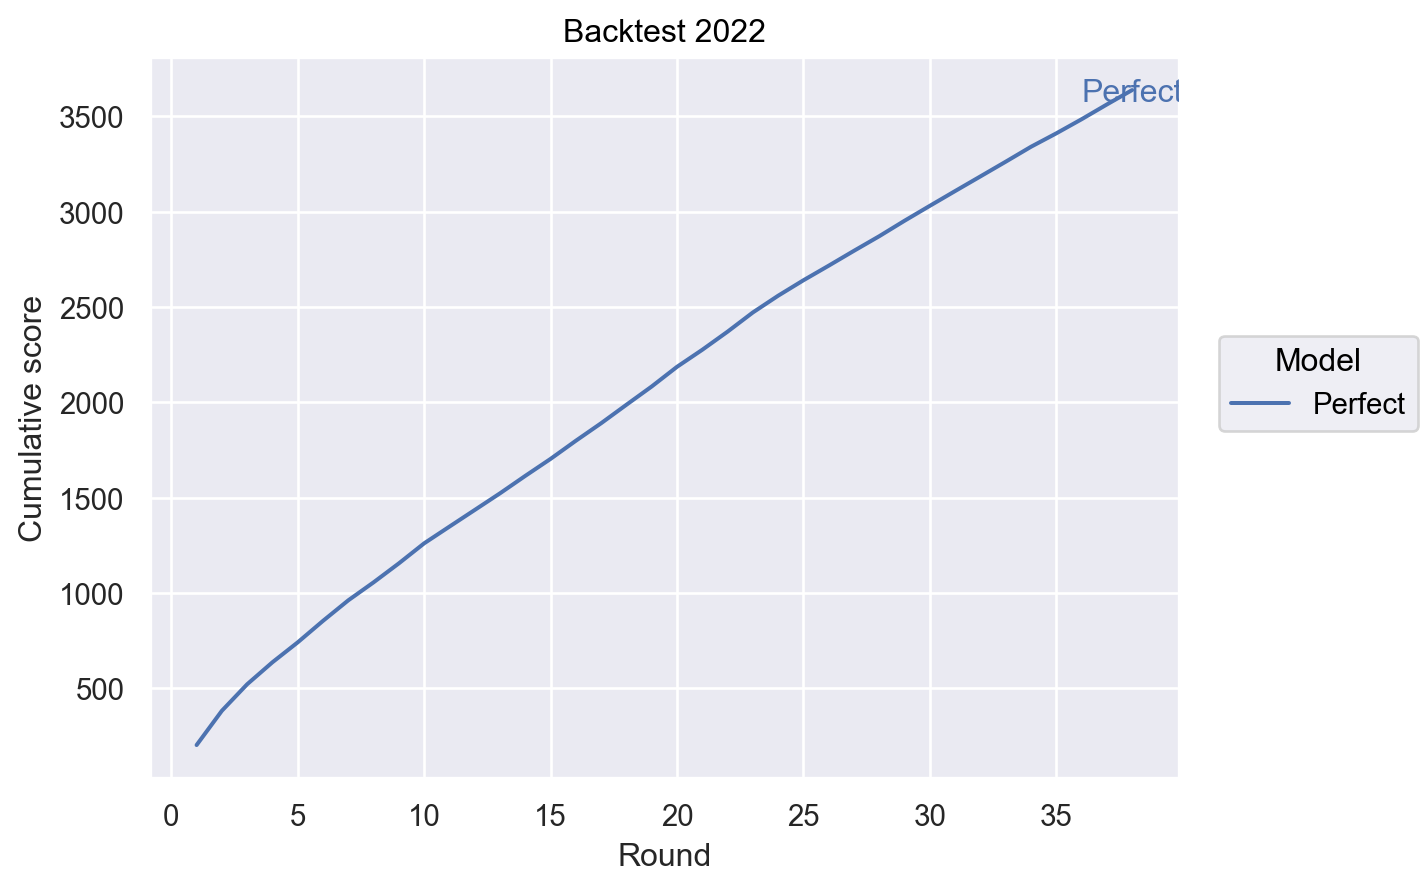

In [14]:
#| label: team-picking-backtest-score
import seaborn.objects as so


def add_backtest(fig: so.Plot, players: pl.DataFrame, color: str) -> so.Plot:
    teams = backtest(players)
    campaign = summarize(teams, color)
    label = campaign.tail(1)
    fig = fig.add(so.Line(), data=campaign).add(so.Text(), data=label)
    return fig


def summarize(teams: pl.DataFrame, model: str) -> pl.DataFrame:
    captains = (
        teams.filter(pl.col("position") != 6)
        .filter(pl.col("estimate") == pl.col("estimate").over("round").max())
        .with_columns(captain=2.0)
        .select("round", "id", "captain")
    )  # TODO review
    campaign = (
        teams.join(captains, on=["round", "id"], how="left")
        .with_columns(score=pl.col("score") * pl.col("captain").fill_null(1.0))
        .group_by("round")
        .agg(score=pl.col("score").sum())
        .with_columns(score=pl.col("score").cumsum(), model=pl.lit(model))
    )
    return campaign


campaign = summarize(teams, "Perfect")
fig = so.Plot(
    campaign, x="round", y="score", color="model", text="model"
).label(title="Backtest 2022", x="Round", y="Cumulative score", color="Model")
fig = add_backtest(fig, players, "Perfect")
fig

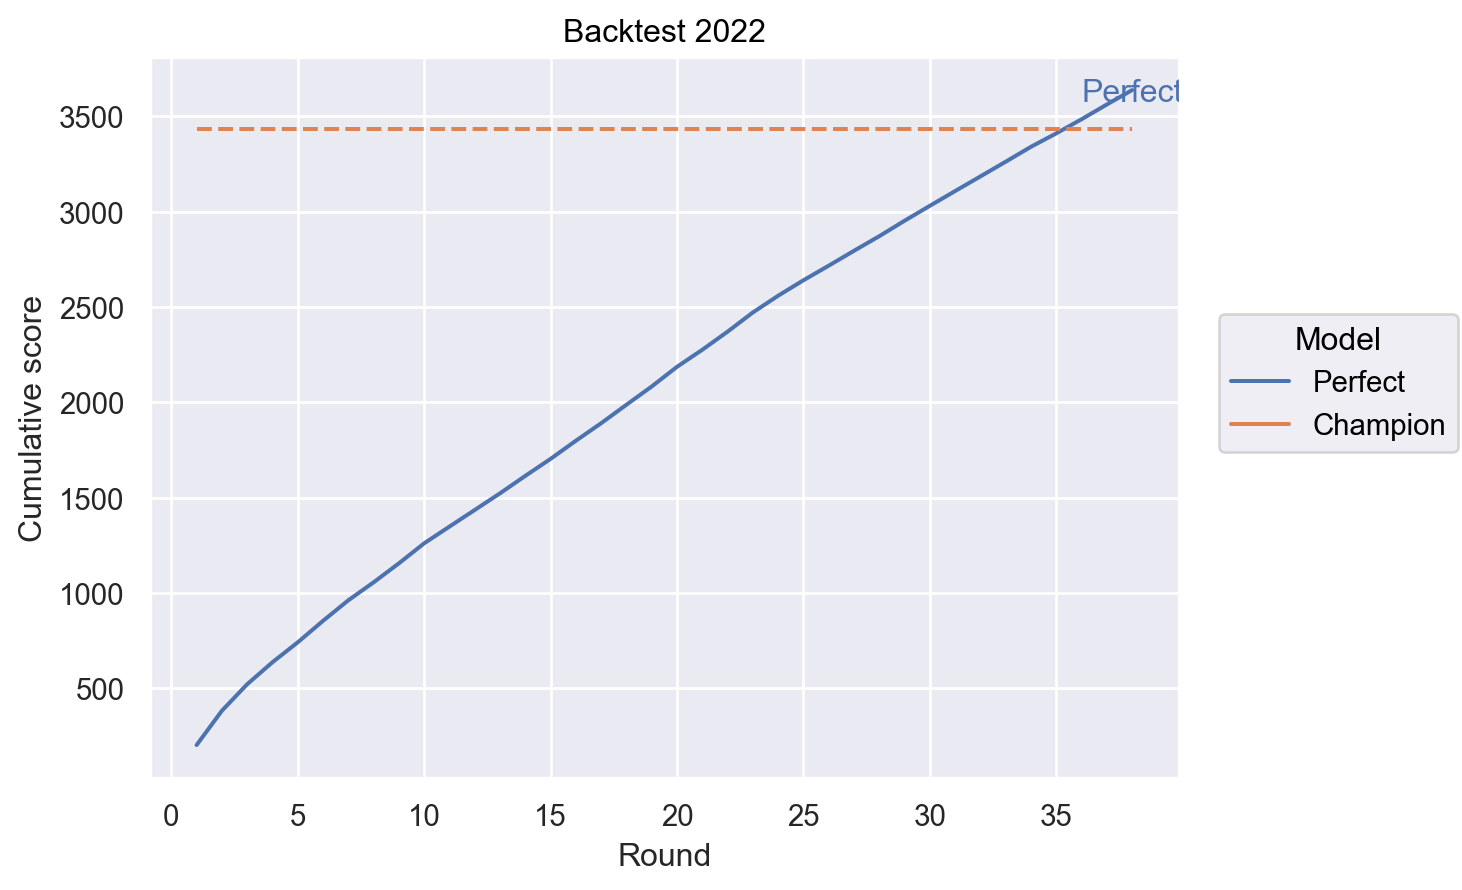

In [15]:
#| label: champion-score
champion = campaign.with_columns(
    score=pl.lit(3434.37), model=pl.lit("Champion")
)
fig = fig.add(so.Line(linestyle="dashed"), data=champion)
fig

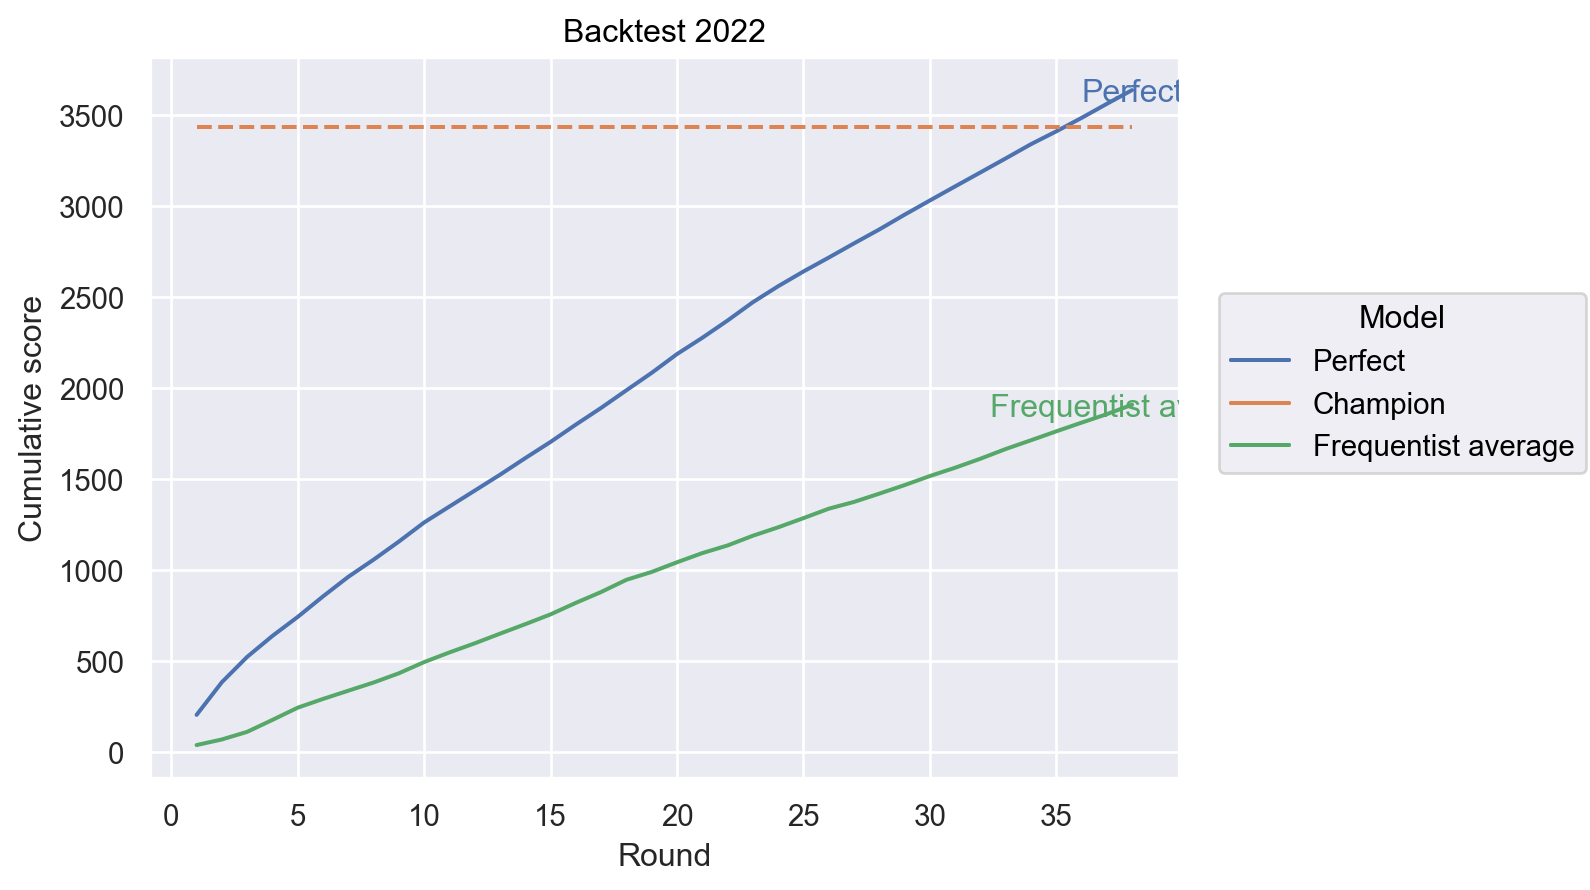

In [16]:
#| label: classic-average
players = players.with_columns(
    estimate=pl.when(pl.col("round") == 1)
    .then(pl.col("value"))
    .otherwise(pl.col("average"))
)
fig = add_backtest(fig, players, "Frequentist average")
fig

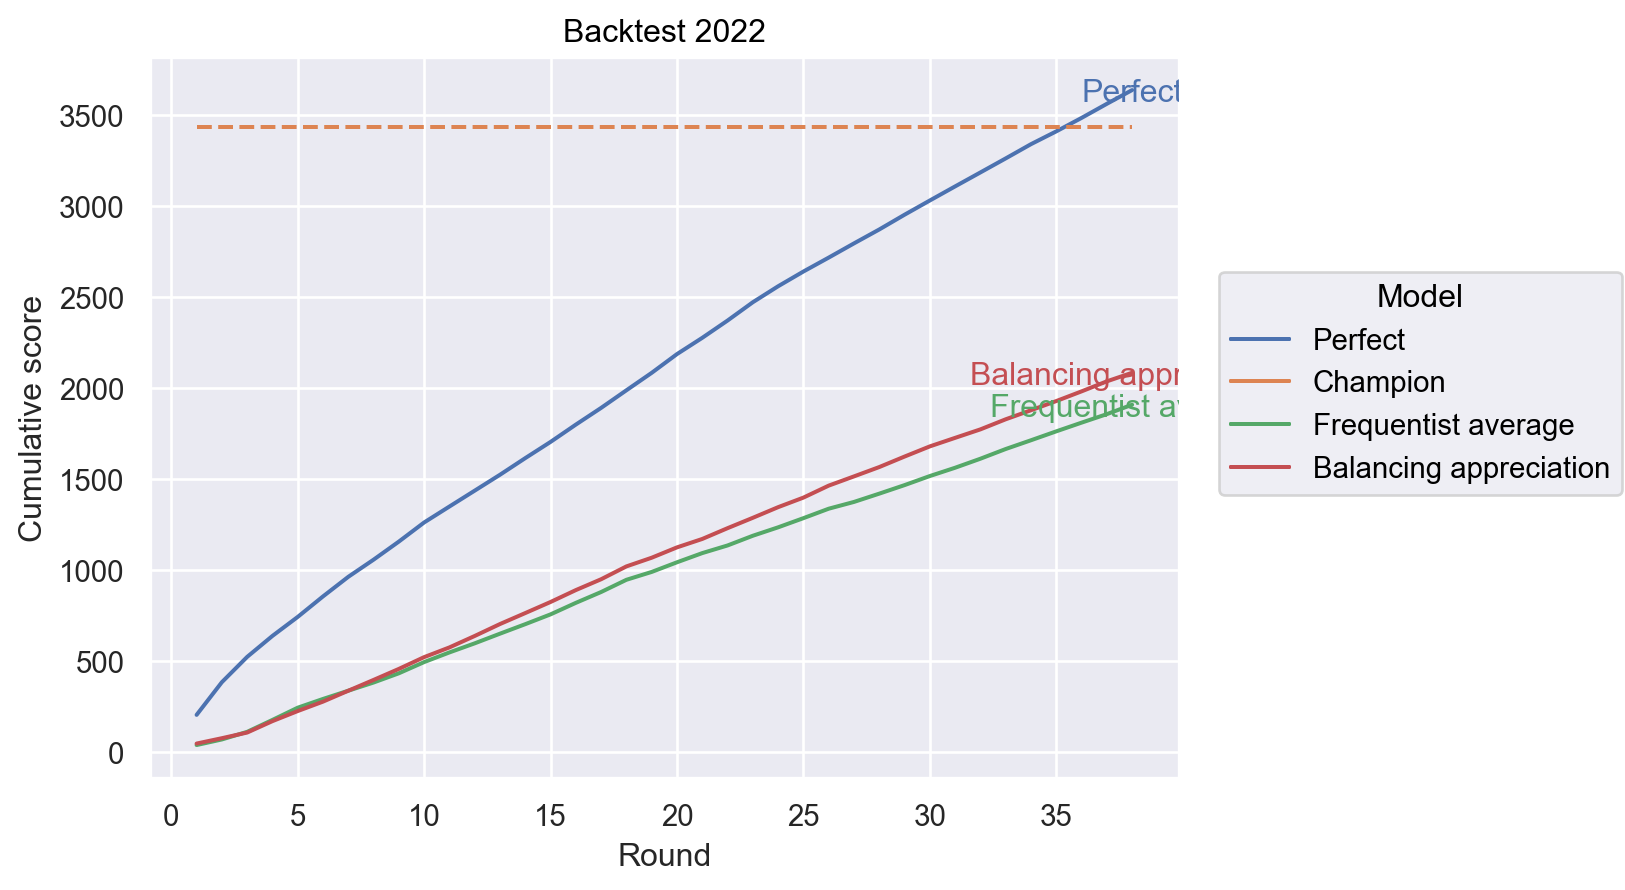

In [17]:
#| label: balancing-appreciation
players = players.with_columns(estimate=pl.col("estimate") - pl.col("minimum"))
fig = add_backtest(fig, players, "Balancing appreciation")
fig

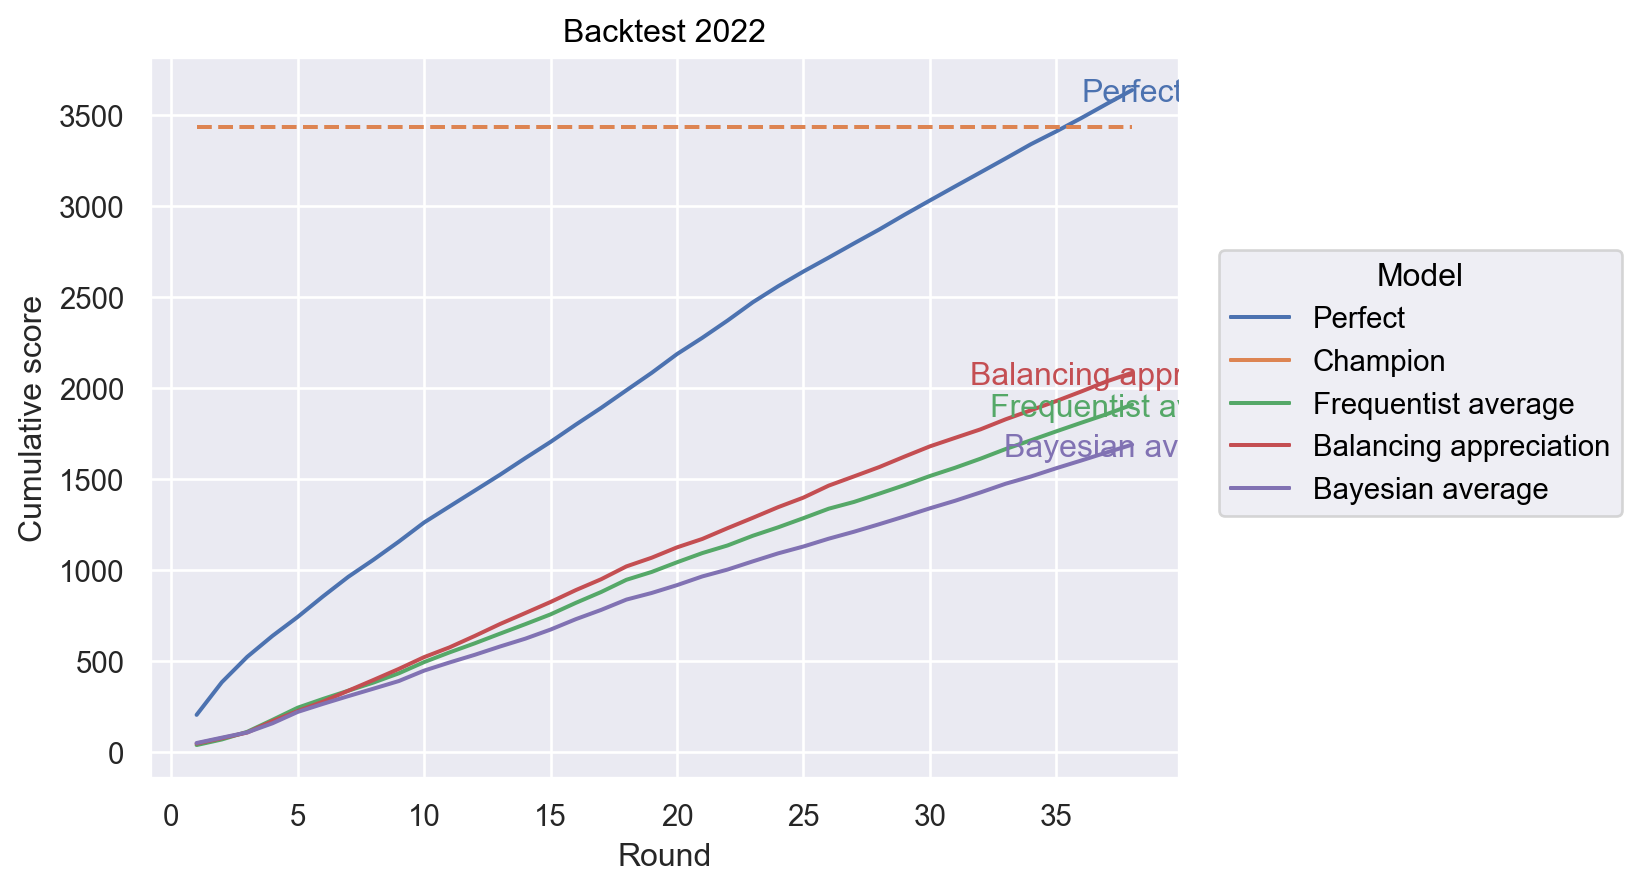

In [18]:
#| label: bayesian-average
c = 1
players = players.with_columns(
    estimate=(pl.col("average") * pl.col("games") + 1 * pl.col("value"))
    / (pl.col("games") + c)
)
fig = add_backtest(fig, players, "Bayesian average")
fig